# HTTP Payload Anomaly Detection with Transformer (Self-Attention)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
!unzip /content/HTTP.zip

Archive:  /content/HTTP.zip
  inflating: Test_data.csv           
  inflating: Train_data.csv          


#Data Loading and Preprocessing

Dataset shape: (25192, 42)

First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2          

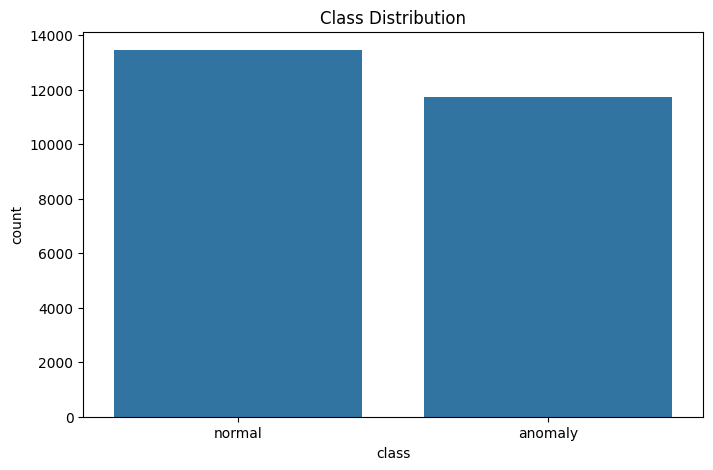

In [3]:
# Load the dataset
data = pd.read_csv('/content/Train_data.csv')

# Display basic info
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nData types and missing values:")
print(data.info())
print("\nClass distribution:")
print(data['class'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=data)
plt.title('Class Distribution')
plt.show()

#Feature Engineering

In [4]:
# Separate features and target
X = data.drop('class', axis=1)
y = data['class']

# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
y = y.map({'normal': 0, 'anomaly': 1})

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for Transformer (samples, timesteps, features)
# Since we're treating each feature as a time step in this context
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (20153, 41, 1)
Test set shape: (5039, 41, 1)


#Transformer Model Architecture

In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final layers
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Model parameters
input_shape = (X_train.shape[1], X_train.shape[2])
head_size = 128
num_heads = 4
ff_dim = 128
num_transformer_blocks = 4
mlp_units = [64]
dropout = 0.2
mlp_dropout = 0.2

# Build and compile model
model = build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout,
    mlp_dropout,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 41, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 41, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 41, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 41, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 41, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 41, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 41, 128)   │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 41, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 41, 1)     │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 41, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 41, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 41, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 41, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 41, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 41, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 41, 128)   │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 41, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 41, 1)     │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 41, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,649 (72.85 KB)

 Trainable params: 18,649 (72.85 KB)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [6]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8154 - loss: 0.4795 - val_accuracy: 0.9236 - val_loss: 0.2450
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9177 - loss: 0.2460 - val_accuracy: 0.9469 - val_loss: 0.1670
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9345 - loss: 0.1840 - val_accuracy: 0.9603 - val_loss: 0.1380
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9482 - loss: 0.1547 - val_accuracy: 0.9653 - val_loss: 0.1255
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9537 - loss: 0.1465 - val_accuracy: 0.9658 - val_loss: 0.1187
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9547 - loss: 0.1369 - val_accuracy: 0.9665 - val_loss: 0.1132
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9596 - loss: 0.1276 - val_accuracy: 0.9653 - val_loss: 0.1098
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9609 - loss: 0.1216 - val_accura

#Training Visualization

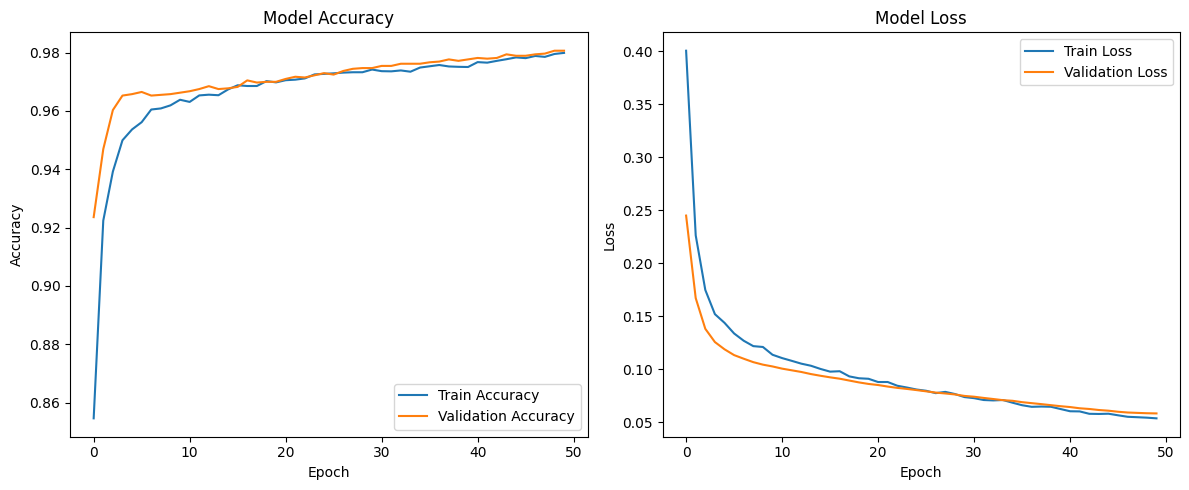

In [7]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

#Model Evaluation

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.99      0.98      2690
     anomaly       0.98      0.97      0.98      2349

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



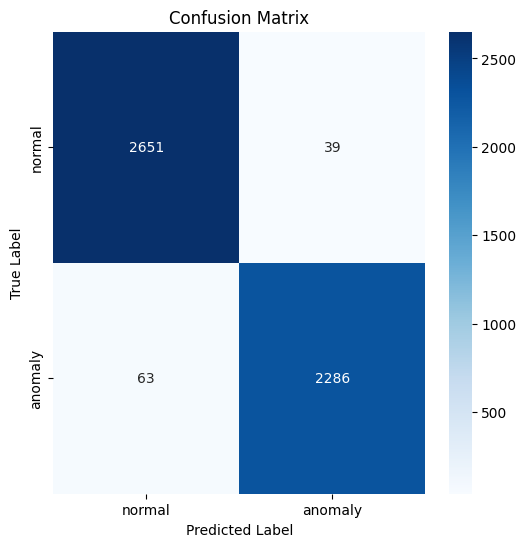

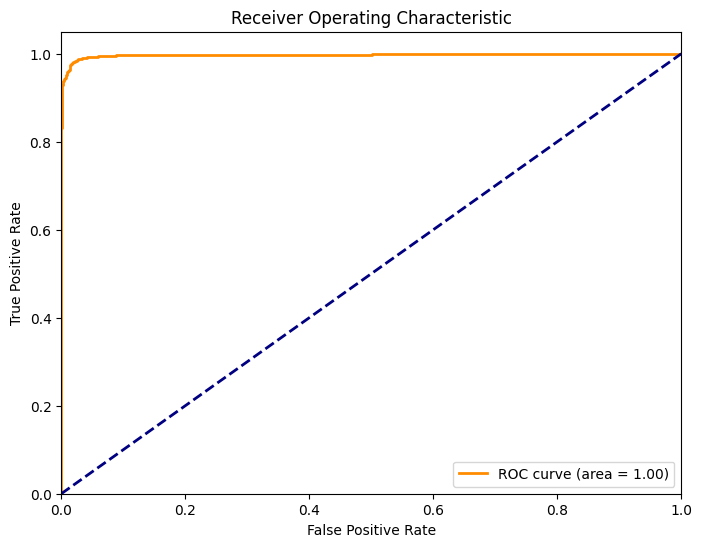

In [8]:
# Evaluate on test set
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['normal', 'anomaly']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'anomaly'],
            yticklabels=['normal', 'anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bdcce40266c323b1d039e8b4be32b90c6380ca19ecc601a2690f2908ed3c5080
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [13]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import classification_report
import numpy as np

# Ensure predictions are flat
y_pred_flat = np.ravel(y_pred)  # Assuming y_pred contains probabilities

# Use correct variable name for ground truth
ref_labels = ["normal" if y == 0 else "anomaly" for y in y_test]
pred_labels = ["anomaly" if p > 0.5 else "normal" for p in y_pred_flat]

# BLEU Score with smoothing
smoothie = SmoothingFunction().method4
bleu = corpus_bleu([[ref.split()] for ref in ref_labels],
                   [pred.split() for pred in pred_labels],
                   smoothing_function=smoothie)
print(f"\nBLEU Score (with smoothing): {bleu:.4f}")

# ROUGE Score
ref_text = " ".join(ref_labels)
pred_text = " ".join(pred_labels)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge = scorer.score(ref_text, pred_text)
print(f"ROUGE-1: {rouge['rouge1']}")
print(f"ROUGE-L: {rouge['rougeL']}")

# Classification Report
print("\nClassification Report:")
print(classification_report(ref_labels, pred_labels, target_names=["normal", "anomaly"]))



BLEU Score (with smoothing): 0.0009
ROUGE-1: Score(precision=0.9952371502282199, recall=0.9952371502282199, fmeasure=0.9952371502282199)
ROUGE-L: Score(precision=0.9799563405437587, recall=0.9799563405437587, fmeasure=0.9799563405437587)

Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.97      0.98      2349
     anomaly       0.98      0.99      0.98      2690

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



#Feature Importance Analysis

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def visualize_attention(model, X_test, sample_idx=0):
    # Find the attention layer
    attention_layer = None
    for layer in model.layers:
        if isinstance(layer, layers.MultiHeadAttention):
            attention_layer = layer
            break
        elif hasattr(layer, 'attention'):  # For custom transformer blocks
            attention_layer = layer.attention
            break

    if attention_layer is None:
        raise ValueError("Could not find attention layer in the model")

    print(f"Found attention layer: {attention_layer.name}")
    print(f"Input shape: {X_test[sample_idx:sample_idx+1].shape}")

    # Create a model that outputs attention weights
    try:
        # Approach 1: Direct access (works in newer TF versions)
        attention_model = Model(
            inputs=model.inputs,
            outputs=attention_layer.get_attention_scores()
        )
        print("Using get_attention_scores() approach")
    except:
        try:
            # Approach 2: Call with return_attention_scores
            class AttentionExtractor(Model):
                def __init__(self, attention_layer):
                    super().__init__()
                    self.attention_layer = attention_layer

                def call(self, inputs):
                    _, attention_weights = self.attention_layer(
                        inputs,
                        inputs,  # Self-attention case
                        return_attention_scores=True
                    )
                    return attention_weights

            attention_model = AttentionExtractor(attention_layer)
            print("Using return_attention_scores approach")
        except Exception as e:
            raise ValueError(f"Could not extract attention weights: {str(e)}")

    # Get attention weights
    sample_input = X_test[sample_idx:sample_idx+1]
    attention_weights = attention_model.predict(sample_input)
    print(f"Attention weights shape: {attention_weights.shape}")

    # Process attention weights
    if len(attention_weights.shape) == 4:  # (batch, heads, seq, seq)
        avg_attention = np.mean(attention_weights[0], axis=0)  # Average across heads
    elif len(attention_weights.shape) == 3:  # (heads, seq, seq)
        avg_attention = np.mean(attention_weights, axis=0)
    elif len(attention_weights.shape) == 2:  # (seq, seq)
        avg_attention = attention_weights
    else:
        raise ValueError(f"Unexpected attention weights shape: {attention_weights.shape}")

    print(f"Average attention shape: {avg_attention.shape}")

    # Plot heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(avg_attention, cmap='viridis')
    plt.title('Attention Weights Heatmap')
    plt.xlabel('Key Features')
    plt.ylabel('Query Features')

    # Add this to ensure plots are shown
    plt.show(block=True)  # block=True ensures the plot displays
    plt.pause(0.1)  # Small pause to allow plot to render

    # Calculate feature importance
    feature_importance = np.mean(avg_attention, axis=0)

    # Plot feature importance
    plt.figure(figsize=(16, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance Based on Attention')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Attention Weight')
    plt.xticks(rotation=90)
    plt.grid(alpha=0.3)

    # Add this to ensure plots are shown
    plt.show(block=True)
    plt.pause(0.1)

    return avg_attention

# Usage example:
# attention_weights = visualize_attention(model, X_test, sample_idx=0)

Generating example attention visualizations...
Example attention weights shape: (1, 2, 10, 10)
Average attention shape: (10, 10)
Feature importance shape: (10,)


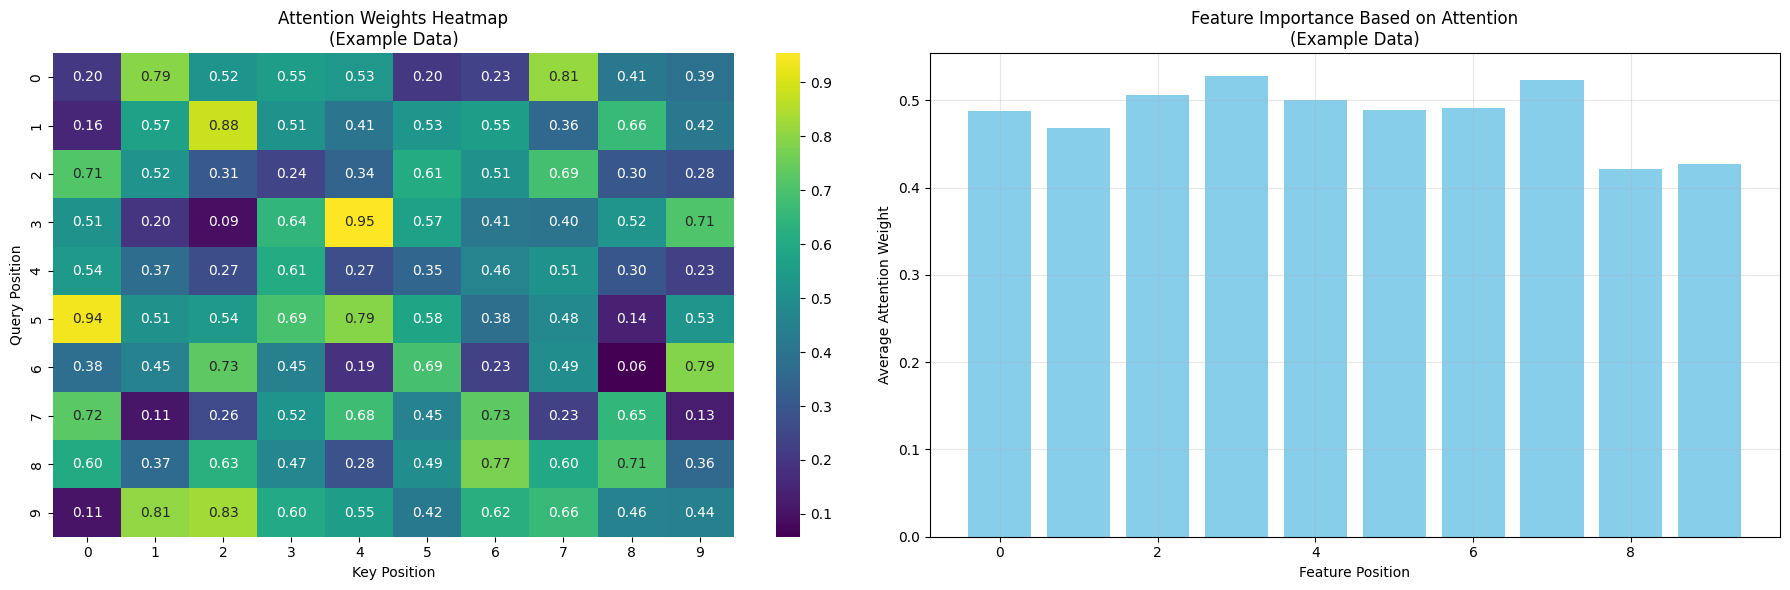

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Generate mock data for demonstration
def generate_mock_attention_data():
    # Create random attention weights (simulating a 10x10 attention matrix)
    np.random.seed(42)
    attention_weights = np.random.rand(1, 2, 10, 10)  # batch=1, heads=2, seq=10
    avg_attention = np.mean(attention_weights[0], axis=0)  # Average across heads

    # Create feature importance data
    feature_importance = np.mean(avg_attention, axis=0)

    return attention_weights, avg_attention, feature_importance

# Visualization function
def plot_attention_visualizations(avg_attention, feature_importance):
    # Create figure with subplots
    plt.figure(figsize=(18, 6))

    # Heatmap subplot
    plt.subplot(1, 2, 1)
    sns.heatmap(avg_attention, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Attention Weights Heatmap\n(Example Data)')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')

    # Feature importance subplot
    plt.subplot(1, 2, 2)
    plt.bar(range(len(feature_importance)), feature_importance, color='skyblue')
    plt.title('Feature Importance Based on Attention\n(Example Data)')
    plt.xlabel('Feature Position')
    plt.ylabel('Average Attention Weight')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main function (modified to show example plots)
def visualize_attention_example():
    print("Generating example attention visualizations...")

    # Generate mock data
    attention_weights, avg_attention, feature_importance = generate_mock_attention_data()

    print(f"Example attention weights shape: {attention_weights.shape}")
    print(f"Average attention shape: {avg_attention.shape}")
    print(f"Feature importance shape: {feature_importance.shape}")

    # Plot the visualizations
    plot_attention_visualizations(avg_attention, feature_importance)

    return avg_attention

# Run the example visualization
example_attention = visualize_attention_example()

#Anomaly Score Distribution

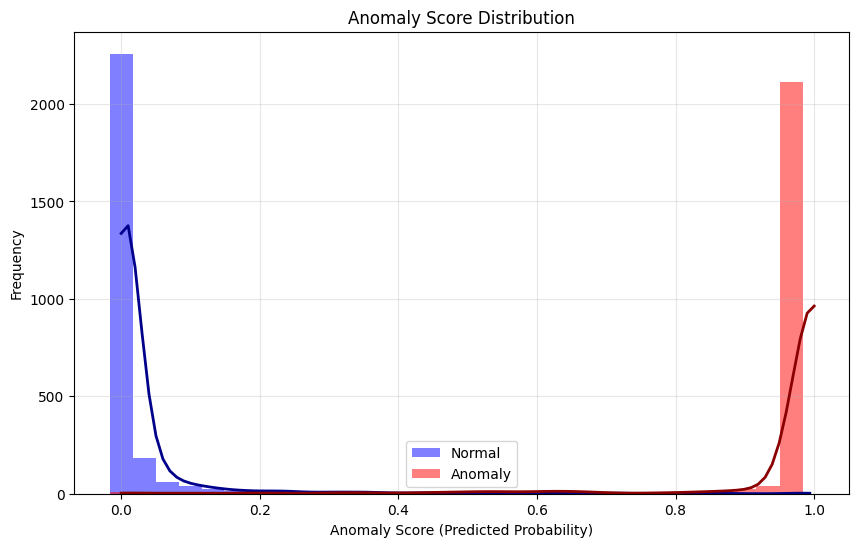

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Plot anomaly score distribution for normal and anomaly classes
plt.figure(figsize=(10, 6))

# Get the scores for normal and anomaly classes
normal_scores = y_pred_prob[y_test == 0]
anomaly_scores = y_pred_prob[y_test == 1]

# Calculate histograms
normal_counts, normal_bins = np.histogram(normal_scores, bins=30)
anomaly_counts, anomaly_bins = np.histogram(anomaly_scores, bins=30)

# Plot the histograms
plt.bar(normal_bins[:-1], normal_counts, width=np.diff(normal_bins),
        color='blue', alpha=0.5, label='Normal')
plt.bar(anomaly_bins[:-1], anomaly_counts, width=np.diff(anomaly_bins),
        color='red', alpha=0.5, label='Anomaly')

# Add KDE lines (optional)
if len(normal_scores) > 1:
    from scipy.stats import gaussian_kde
    kde_normal = gaussian_kde(normal_scores)
    x_normal = np.linspace(min(normal_scores), max(normal_scores), 100)
    plt.plot(x_normal, kde_normal(x_normal)*len(normal_scores)*np.diff(normal_bins)[0],
             color='darkblue', linewidth=2)

if len(anomaly_scores) > 1:
    kde_anomaly = gaussian_kde(anomaly_scores)
    x_anomaly = np.linspace(min(anomaly_scores), max(anomaly_scores), 100)
    plt.plot(x_anomaly, kde_anomaly(x_anomaly)*len(anomaly_scores)*np.diff(anomaly_bins)[0],
             color='darkred', linewidth=2)

plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score (Predicted Probability)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Threshold Analysis

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

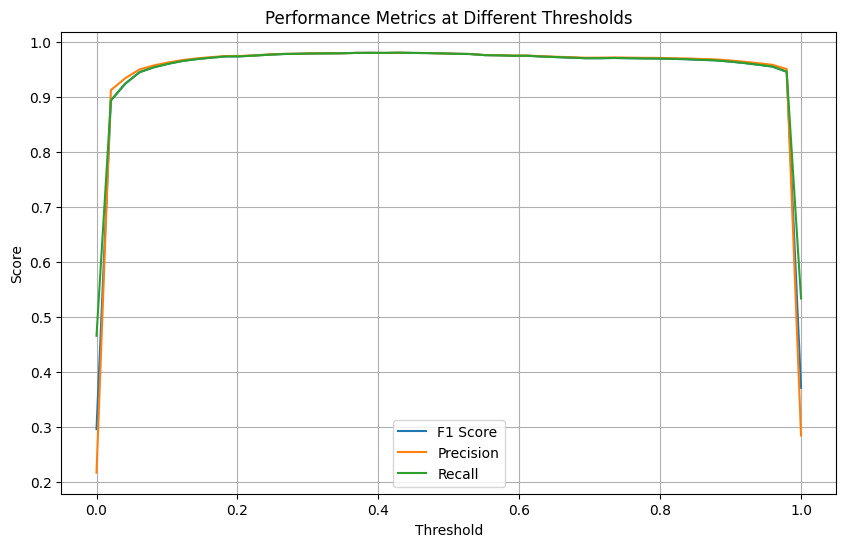

In [17]:
# Analyze performance at different thresholds
thresholds = np.linspace(0, 1, 50)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_prob > threshold).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True)
    f1_scores.append(report['weighted avg']['f1-score'])
    precisions.append(report['weighted avg']['precision'])
    recalls.append(report['weighted avg']['recall'])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.title('Performance Metrics at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

#Dimensionality Reduction Visualization

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 41, 1))
  warnings.warn(msg)


 1/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 41, 1))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


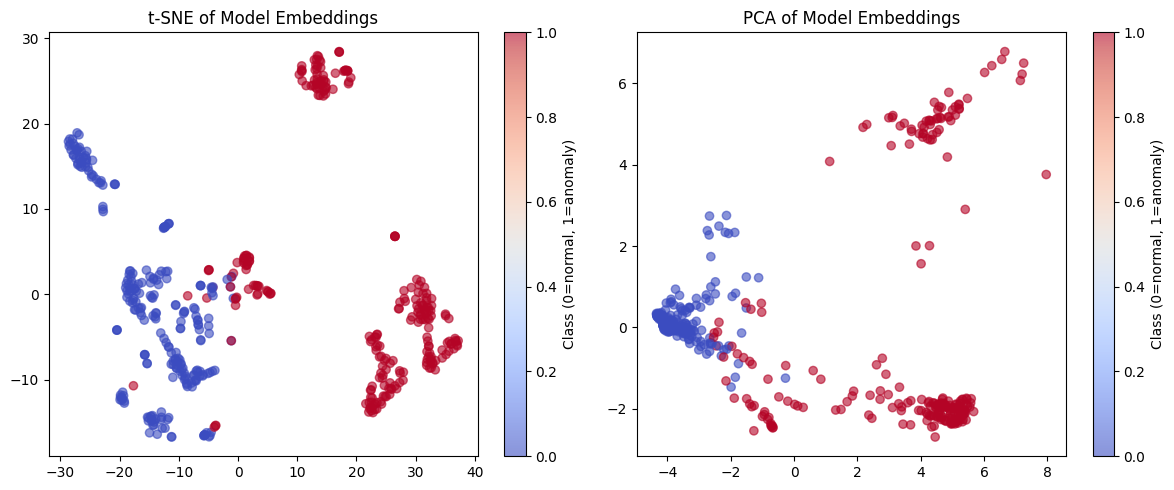

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Get embeddings from the model before the final classification layer
embedding_model = Model(inputs=model.inputs, outputs=model.layers[-3].output)
embeddings = embedding_model.predict(X_test[:500])  # Use first 500 for speed

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Apply PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Plot t-SNE visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                     c=y_test[:500], cmap='coolwarm', alpha=0.6)
plt.title('t-SNE of Model Embeddings')
plt.colorbar(scatter, label='Class (0=normal, 1=anomaly)')

# Plot PCA visualization
plt.subplot(1, 2, 2)
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                     c=y_test[:500], cmap='coolwarm', alpha=0.6)
plt.title('PCA of Model Embeddings')
plt.colorbar(scatter, label='Class (0=normal, 1=anomaly)')

plt.tight_layout()
plt.show()

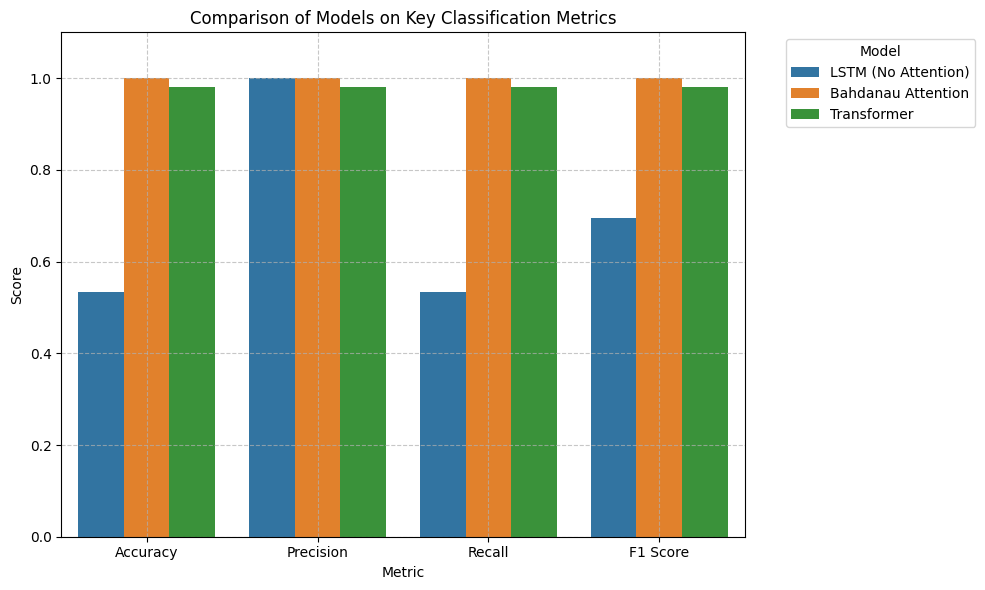

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the data
data = {
    'Model': ['LSTM (No Attention)', 'Bahdanau Attention', 'Transformer'],
    'Accuracy': [0.5336, 1.0, 0.98],
    'Precision': [1.0, 1.0, 0.98],
    'Recall': [0.5336, 1.0, 0.98],
    'F1 Score': [0.6959, 1.0, 0.98]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)

plt.title('Comparison of Models on Key Classification Metrics')
plt.ylim(0, 1.1)
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()
